In [1]:
import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings("ignore", category=ConvergenceWarning)
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

import itertools
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from PIL import Image
from sklearn.metrics import classification_report, f1_score , confusion_matrix


import tensorflow as tf
from tensorflow import keras
from keras.layers import Dense, Dropout , BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers,models,Model
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.callbacks import Callback, EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy('mixed_float16')


print(tf.__version__)

The dtype policy mixed_float16 may run slowly because this machine does not have a GPU. Only Nvidia GPUs with compute capability of at least 7.0 run quickly with mixed_float16.
If you will use compatible GPU(s) not attached to this host, e.g. by running a multi-worker model, you can ignore this warning. This message will only be logged once
2.14.0


# Dataset

In [6]:
dataset = {
             "train_data" : "C:\\Users\\chakr\\OneDrive\\Desktop\\SmartBridge\\Project\\model\\archive\\train",
             "valid_data" : "C:\\Users\\chakr\\OneDrive\\Desktop\\SmartBridge\\Project\\model\\archive\\valid",
             "test_data" : "C:\\Users\\chakr\\OneDrive\\Desktop\\SmartBridge\\Project\\model\\archive\\test"
          }

all_data = []
for path in dataset.values():
    data = {"imgpath": [] , "labels": [] }
    category = os.listdir(path)

    for folder in category:
        folderpath = os.path.join(path , folder)
        filelist = os.listdir(folderpath)
        for file in filelist:
            fpath = os.path.join(folderpath, file)
            data["imgpath"].append(fpath)
            data["labels"].append(folder)
        
        
    all_data.append(data.copy())
    data.clear()

    
    
train_df = pd.DataFrame(all_data[0] , index=range(len(all_data[0]['imgpath'])))
valid_df = pd.DataFrame(all_data[1] , index=range(len(all_data[1]['imgpath'])))
test_df = pd.DataFrame(all_data[2] , index=range(len(all_data[2]['imgpath'])))


lb = LabelEncoder()
train_df['encoded_labels'] = lb.fit_transform(train_df['labels'])
valid_df['encoded_labels'] = lb.fit_transform(valid_df['labels'])
test_df['encoded_labels'] = lb.fit_transform(test_df['labels'])

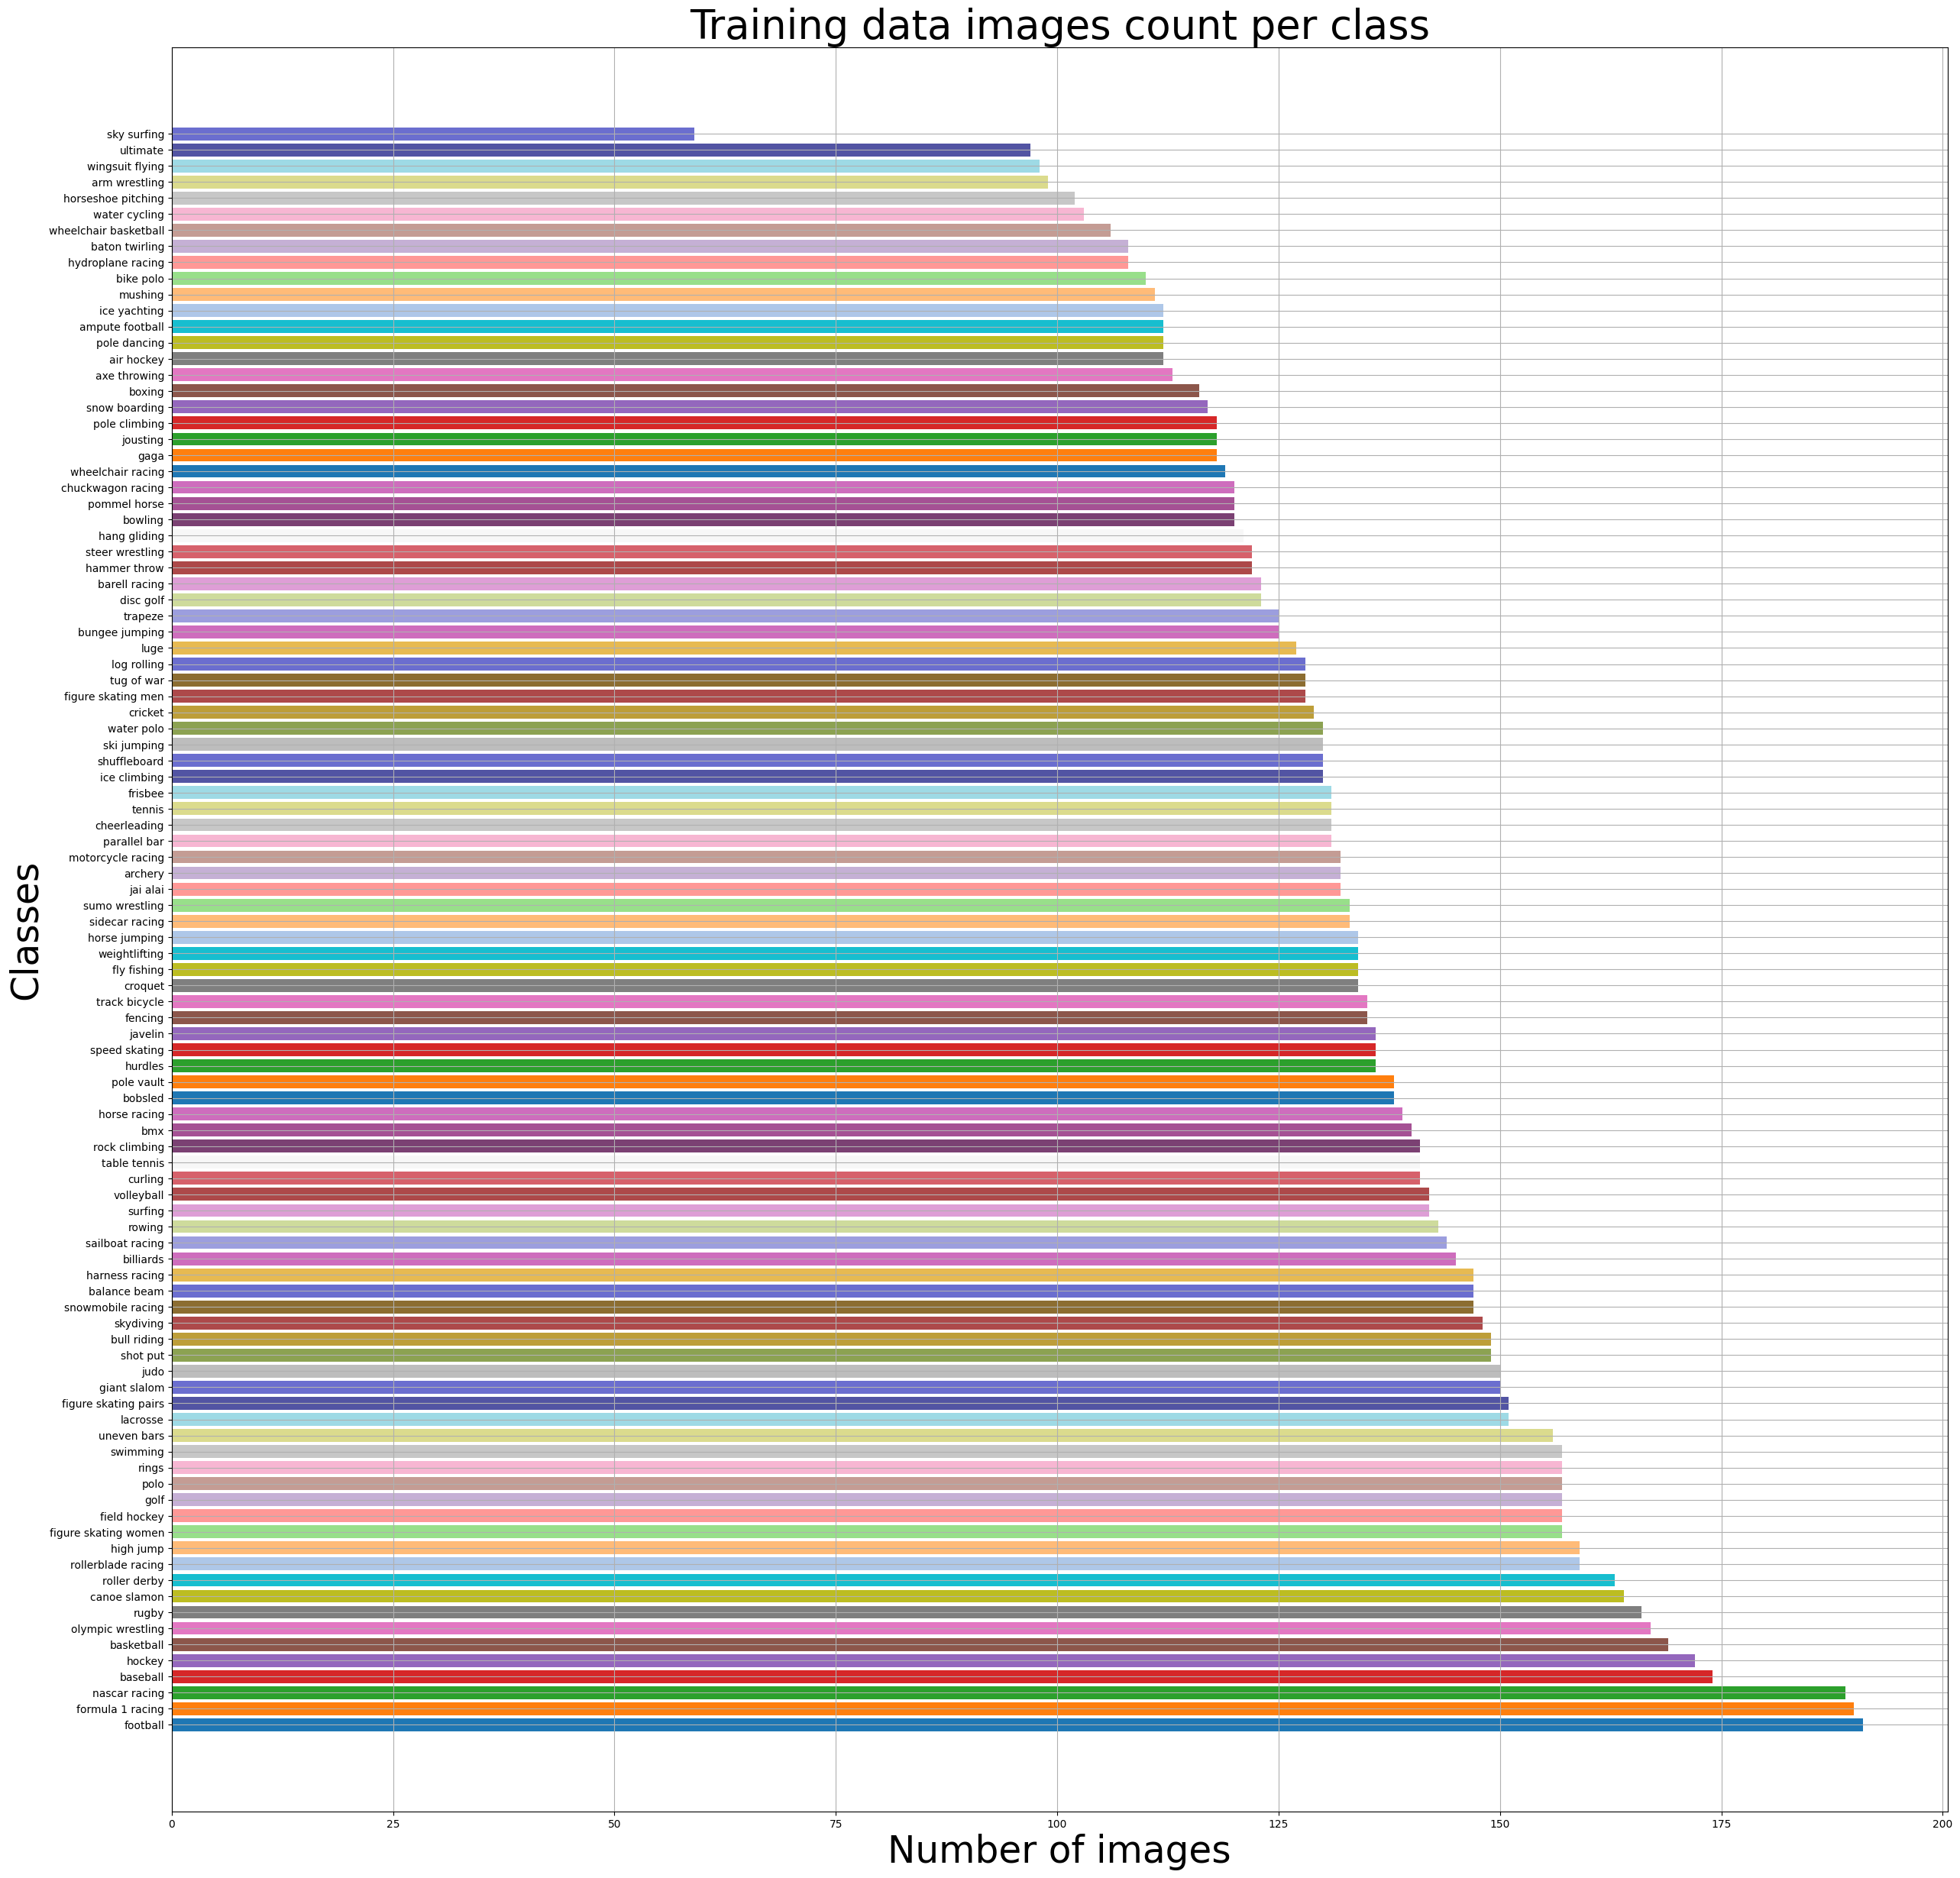

In [7]:
train  = train_df["labels"].value_counts()
label = train.tolist()
index = train.index.tolist()

colors = [
    "#1f77b4", "#ff7f0e", "#2ca02c", "#d62728", "#9467bd",
    "#8c564b", "#e377c2", "#7f7f7f", "#bcbd22", "#17becf",
    "#aec7e8", "#ffbb78", "#98df8a", "#ff9896", "#c5b0d5",
    "#c49c94", "#f7b6d2", "#c7c7c7", "#dbdb8d", "#9edae5",
    "#5254a3", "#6b6ecf", "#bdbdbd", "#8ca252", "#bd9e39",
    "#ad494a", "#8c6d31", "#6b6ecf", "#e7ba52", "#ce6dbd",
    "#9c9ede", "#cedb9c", "#de9ed6", "#ad494a", "#d6616b",
    "#f7f7f7", "#7b4173", "#a55194", "#ce6dbd"
]



plt.figure(figsize=(30,30))
plt.title("Training data images count per class",fontsize=38)
plt.xlabel('Number of images', fontsize=35)
plt.ylabel('Classes', fontsize=35)
plt.barh(index,label, color=colors)
plt.grid(True)
plt.show()

In [8]:
train_df.sample(n=15, random_state=1)

,imgpath,labels,encoded_labels
3449,C:\Users\chakr\OneDrive\Desktop\SmartBridge\Pr...,field hockey,26
5802,C:\Users\chakr\OneDrive\Desktop\SmartBridge\Pr...,horse jumping,42
2979,C:\Users\chakr\OneDrive\Desktop\SmartBridge\Pr...,croquet,22
1034,C:\Users\chakr\OneDrive\Desktop\SmartBridge\Pr...,basketball,8
479,C:\Users\chakr\OneDrive\Desktop\SmartBridge\Pr...,axe throwing,4
9143,C:\Users\chakr\OneDrive\Desktop\SmartBridge\Pr...,rock climbing,67
4737,C:\Users\chakr\OneDrive\Desktop\SmartBridge\Pr...,gaga,34
6433,C:\Users\chakr\OneDrive\Desktop\SmartBridge\Pr...,ice climbing,47
35,C:\Users\chakr\OneDrive\Desktop\SmartBridge\Pr...,air hockey,0
11522,C:\Users\chakr\OneDrive\Desktop\SmartBridge\Pr...,surfing,84


In [9]:
print("----------Train-------------")
print(train_df[["imgpath", "labels"]].head(5))
print(train_df.shape)
print("--------Validation----------")
print(valid_df[["imgpath", "labels"]].head(5))
print(valid_df.shape)
print("----------Test--------------")
print(test_df[["imgpath", "labels"]].head(5))
print(test_df.shape)

----------Train-------------
                                             imgpath      labels
0  C:\Users\chakr\OneDrive\Desktop\SmartBridge\Pr...  air hockey
1  C:\Users\chakr\OneDrive\Desktop\SmartBridge\Pr...  air hockey
2  C:\Users\chakr\OneDrive\Desktop\SmartBridge\Pr...  air hockey
3  C:\Users\chakr\OneDrive\Desktop\SmartBridge\Pr...  air hockey
4  C:\Users\chakr\OneDrive\Desktop\SmartBridge\Pr...  air hockey
(13493, 3)
--------Validation----------
                                             imgpath      labels
0  C:\Users\chakr\OneDrive\Desktop\SmartBridge\Pr...  air hockey
1  C:\Users\chakr\OneDrive\Desktop\SmartBridge\Pr...  air hockey
2  C:\Users\chakr\OneDrive\Desktop\SmartBridge\Pr...  air hockey
3  C:\Users\chakr\OneDrive\Desktop\SmartBridge\Pr...  air hockey
4  C:\Users\chakr\OneDrive\Desktop\SmartBridge\Pr...  air hockey
(500, 3)
----------Test--------------
                                             imgpath      labels
0  C:\Users\chakr\OneDrive\Desktop\SmartBridge\P

# Sample data

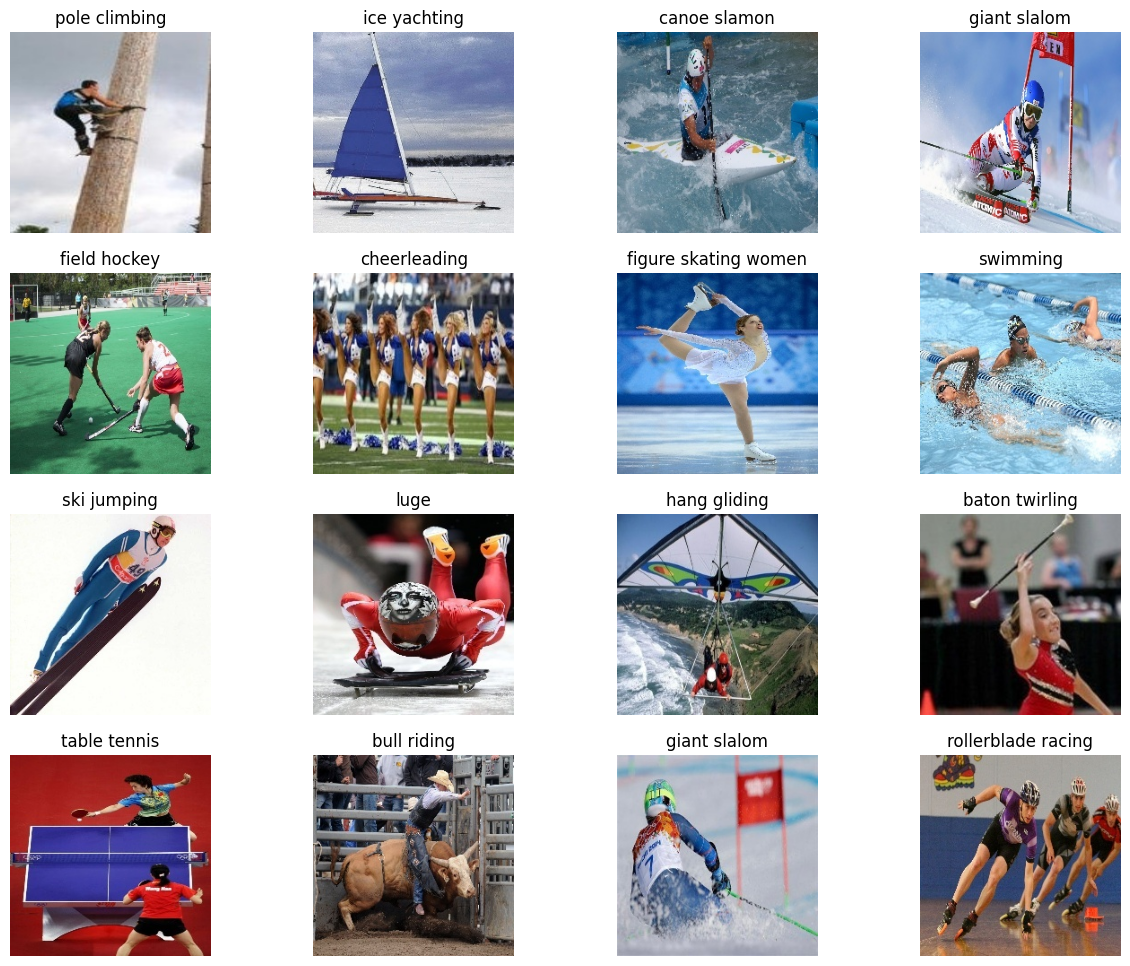

In [10]:
plt.figure(figsize=(15,12))
for i, row in valid_df.sample(n=16).reset_index().iterrows():
    plt.subplot(4,4,i+1)
    image_path = row['imgpath']
    image = Image.open(image_path)
    plt.imshow(image)
    plt.title(row["labels"])
    plt.axis('off')
plt.show()

In [11]:
%%time

BATCH_SIZE = 10
IMAGE_SIZE = (224, 224)


generator = ImageDataGenerator(
    preprocessing_function = tf.keras.applications.efficientnet.preprocess_input,
)

train_images = generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='imgpath',
    y_col='labels',
    target_size=IMAGE_SIZE,
    color_mode='rgb',
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=42,
)

valid_images = generator.flow_from_dataframe(
    dataframe=valid_df,
    x_col='imgpath',
    y_col='labels',
    target_size=IMAGE_SIZE,
    color_mode='rgb',
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=False
)

test_images = generator.flow_from_dataframe(
    dataframe=test_df,
    x_col='imgpath',
    y_col='labels',
    target_size=IMAGE_SIZE,
    color_mode='rgb',
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=False
)

Found 13492 validated image filenames belonging to 100 classes.
Found 500 validated image filenames belonging to 100 classes.
Found 500 validated image filenames belonging to 100 classes.
CPU times: total: 344 ms
Wall time: 469 ms


# Pretrained Model

In [12]:
efficient_net = tf.keras.applications.EfficientNetB0(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet',
    pooling='max'
)

for i, layer in enumerate(efficient_net.layers):
    efficient_net.layers[i].trainable = False

16705208/16705208 [==============================] - 3s 0us/step


In [13]:
num_classes = len(set(train_images.classes))

augment = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal"),
  layers.experimental.preprocessing.RandomRotation(0.1),
  layers.experimental.preprocessing.RandomZoom(0.1),
  layers.experimental.preprocessing.RandomContrast(0.1),
], name='AugmentationLayer')

inputs = layers.Input(shape = (224,224,3), name='inputLayer')
x = augment(inputs)
pretrain_out = efficient_net(x, training = False)
x = layers.Dense(350)(pretrain_out)
x = layers.Activation(activation="relu")(x) 
x = BatchNormalization()(x)
x = layers.Dropout(0.25)(x)
x = layers.Dense(num_classes)(x)
outputs = layers.Activation(activation="softmax", dtype=tf.float32, name='activationLayer')(x)
model = Model(inputs=inputs, outputs=outputs)



model.compile(
    optimizer=Adam(0.0005),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

print(model.summary())

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inputLayer (InputLayer)     [(None, 224, 224, 3)]     0         
                                                                 
 AugmentationLayer (Sequent  (None, 224, 224, 3)       0         
 ial)                                                            
                                                                 
 efficientnetb0 (Functional  (None, 1280)              4049571   
 )                                                               
                                                                 
 dense (Dense)               (None, 350)               448350    
                                                                 
 activation (Activation)     (None, 350)               0         
                                                                 
 batch_normalization (Batch  (None, 350)               1400  

# Transfer Learning Training

In [10]:
history = model.fit(
    train_images,
    steps_per_epoch=len(train_images),
    validation_data=valid_images,
    validation_steps=len(valid_images),
    epochs=10,
    callbacks=[
        EarlyStopping(monitor = "val_loss",
                               patience = 3,
                               restore_best_weights = True), 
        ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, mode='min') 
    ]
)
model.save_weights('./checkpoints/my_checkpoint')

Epoch 1/10
1350/1350 [==============================] - 116s 71ms/step - loss: 1.7769 - accuracy: 0.5745 - val_loss: 0.4791 - val_accuracy: 0.8740 - lr: 5.0000e-04
Epoch 2/10
1350/1350 [==============================] - 43s 32ms/step - loss: 0.8104 - accuracy: 0.7868 - val_loss: 0.3759 - val_accuracy: 0.8820 - lr: 5.0000e-04
Epoch 3/10
1350/1350 [==============================] - 43s 32ms/step - loss: 0.6488 - accuracy: 0.8270 - val_loss: 0.3166 - val_accuracy: 0.9000 - lr: 5.0000e-04
Epoch 4/10
1350/1350 [==============================] - 43s 32ms/step - loss: 0.5908 - accuracy: 0.8414 - val_loss: 0.3276 - val_accuracy: 0.8980 - lr: 5.0000e-04
Epoch 5/10
1350/1350 [==============================] - 43s 32ms/step - loss: 0.5502 - accuracy: 0.8504 - val_loss: 0.3068 - val_accuracy: 0.9000 - lr: 5.0000e-04
Epoch 6/10
1350/1350 [==============================] - 43s 32ms/step - loss: 0.5176 - accuracy: 0.8529 - val_loss: 0.2448 - val_accuracy: 0.9300 - lr: 5.0000e-04
Epoch 7/10
1350/1350 

# Model performance

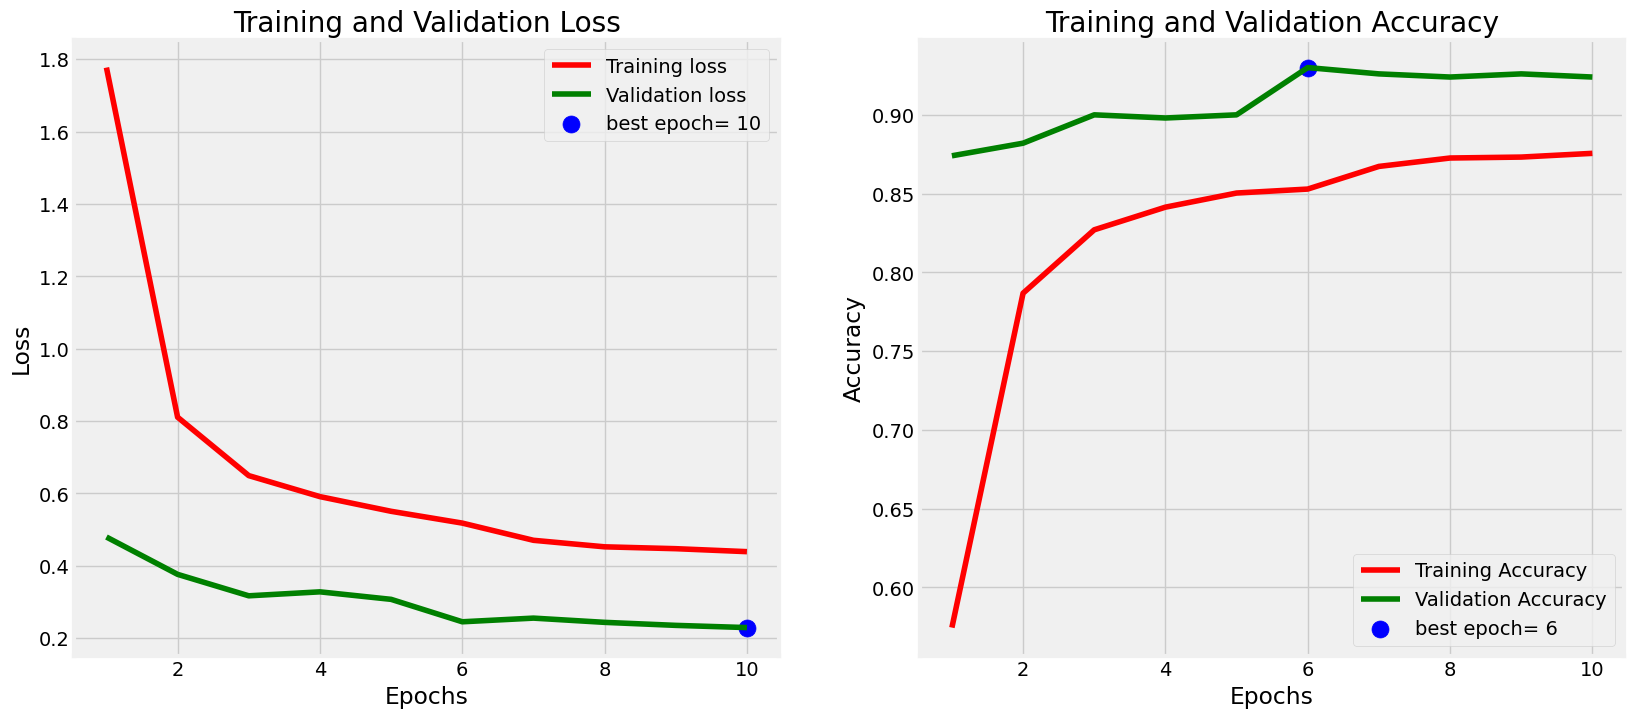

In [11]:
tr_acc = history.history['accuracy']
tr_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]
index_acc = np.argmax(val_acc)
acc_highest = val_acc[index_acc]
Epochs = [i+1 for i in range(len(tr_acc))]
loss_label = f'best epoch= {str(index_loss + 1)}'
acc_label = f'best epoch= {str(index_acc + 1)}'

plt.figure(figsize= (20, 8))
plt.style.use('fivethirtyeight')

plt.subplot(1, 2, 1)
plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'blue', label= loss_label)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'blue', label= acc_label)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout
plt.show()

# Fine Tuning

In [14]:
efficient_net.trainable = True
for layer in efficient_net.layers:
    if isinstance(layer, layers.BatchNormalization):
        layer.trainable = False
        
for l in efficient_net.layers[:10]:
    print(l.name, l.trainable)

model.compile(
    optimizer=Adam(0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

print(model.summary())
history = model.fit(
    train_images,
    steps_per_epoch=len(train_images),
    validation_data=valid_images,
    validation_steps=len(valid_images),
    epochs=25,
    callbacks=[
        EarlyStopping(monitor = "val_loss",
                               patience = 3,
                               restore_best_weights = True),
        ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, mode='min') 
    ]
)
model.save_weights('./checkpoints/my_checkpoint')

input_1 True
rescaling True
normalization True
rescaling_1 True
stem_conv_pad True
stem_conv True
stem_bn False
stem_activation True
block1a_dwconv True
block1a_bn False
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inputLayer (InputLayer)     [(None, 224, 224, 3)]     0         
                                                                 
 AugmentationLayer (Sequent  (None, None, None, None   0         
 ial)                        )                                   
                                                                 
 efficientnetb0 (Functional  (None, 1280)              4049571   
 )                                                               
                                                                 
 dense (Dense)               (None, 350)               448350    
                                                                 
 activation (Activation

# Model performance

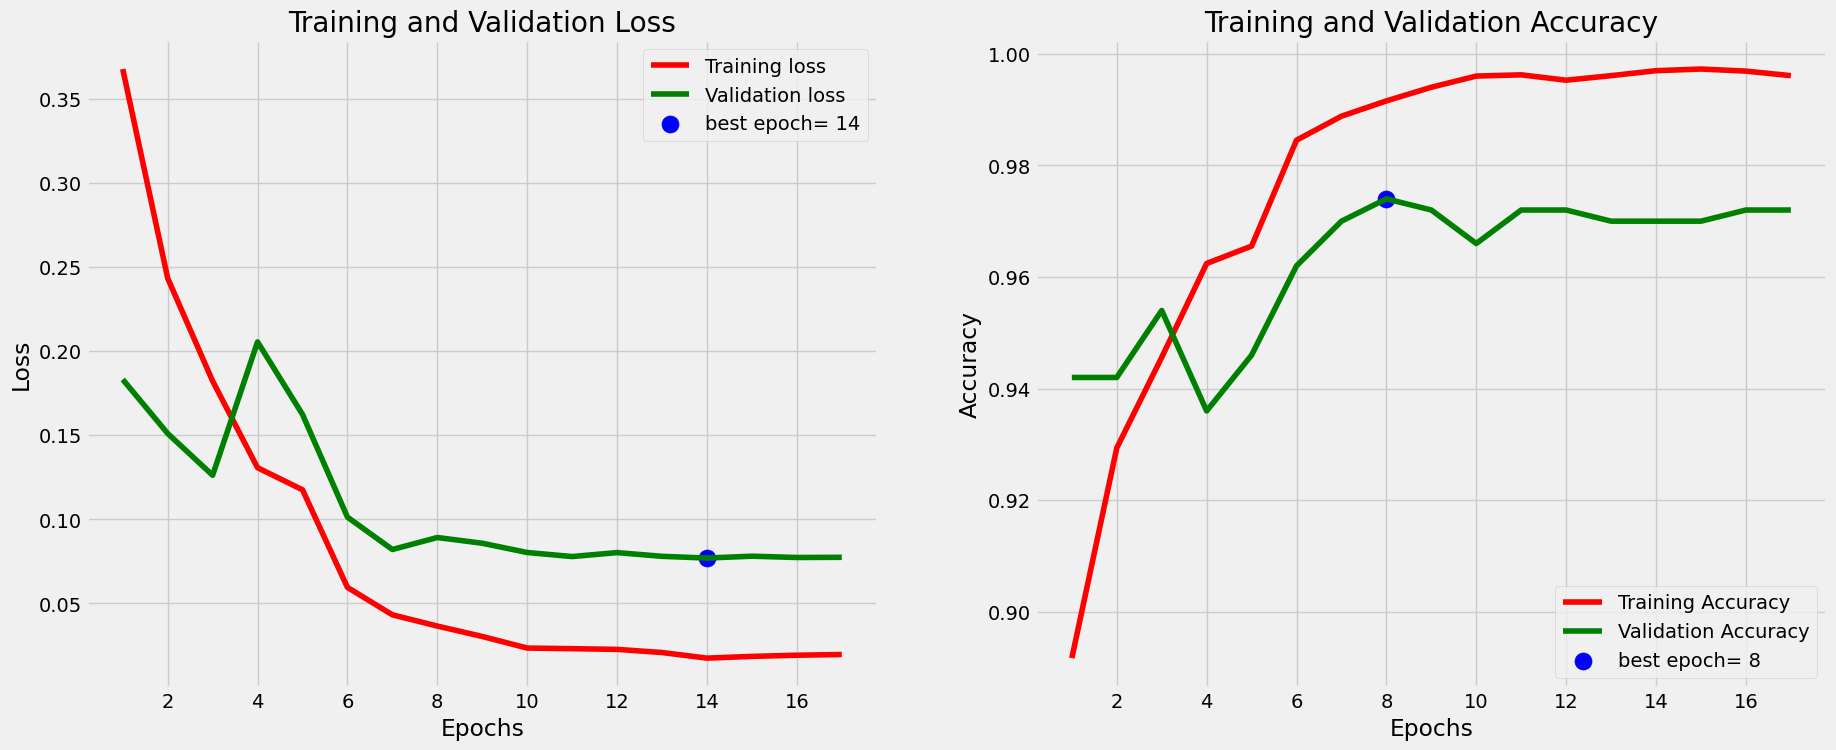

In [15]:
tr_acc = history.history['accuracy']
tr_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]
index_acc = np.argmax(val_acc)
acc_highest = val_acc[index_acc]
Epochs = [i+1 for i in range(len(tr_acc))]
loss_label = f'best epoch= {str(index_loss + 1)}'
acc_label = f'best epoch= {str(index_acc + 1)}'


plt.figure(figsize= (20, 8))
plt.style.use('fivethirtyeight')

plt.subplot(1, 2, 1)
plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'blue', label= loss_label)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'blue', label= acc_label)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout
plt.show()

# Model Evaluation

In [16]:
results = model.evaluate(test_images, verbose=0)

print("Test Loss: {:.5f}".format(results[0]))
print("Test Accuracy: {:.2f} %".format(results[1] * 100))

Test Loss: 0.04174
Test Accuracy: 98.40 %


In [24]:
model.save('sports_model_efficient_net.h5')

# F1 Score, Recall and Precision

In [17]:
y_true = test_images.classes
y_pred = np.argmax(model.predict(test_images), axis = 1)
f1 = f1_score(y_true, y_pred, average='macro')
print("F1 Score:", f1)
print(classification_report(y_true, y_pred, target_names=test_images.class_indices.keys()))

50/50 [==============================] - 3s 30ms/step
F1 Score: 0.9838636363636364
                       precision    recall  f1-score   support

           air hockey       1.00      1.00      1.00         5
      ampute football       1.00      1.00      1.00         5
              archery       1.00      1.00      1.00         5
        arm wrestling       1.00      1.00      1.00         5
         axe throwing       1.00      1.00      1.00         5
         balance beam       1.00      1.00      1.00         5
        barell racing       1.00      1.00      1.00         5
             baseball       1.00      1.00      1.00         5
           basketball       1.00      1.00      1.00         5
       baton twirling       1.00      1.00      1.00         5
            bike polo       1.00      1.00      1.00         5
            billiards       1.00      1.00      1.00         5
                  bmx       1.00      0.80      0.89         5
              bobsled       1.00  

# Predictions

In [18]:
classes = dict(zip(test_images.class_indices.values(), test_images.class_indices.keys()))
Predictions = pd.DataFrame({"Image Index" : list(range(len(test_images.labels))), 
                            "Test Labels" : test_images.labels, 
                            "Test Classes" : [classes[i] for i in test_images.labels],
                            "Prediction Labels" : y_pred,
                            "Prediction Classes" : [classes[i] for i in y_pred],
                            "Path": test_images.filenames,
                            "Prediction Probability" : [x for x in np.asarray(tf.reduce_max(model.predict(test_images), axis = 1))]
                           })
Predictions.head(8)

50/50 [==============================] - 2s 31ms/step


,Image Index,Test Labels,Test Classes,Prediction Labels,Prediction Classes,Path,Prediction Probability
0,0,13,bobsled,13,bobsled,/kaggle/input/sports/test/bobsled/5.jpg,0.999969
1,1,13,bobsled,13,bobsled,/kaggle/input/sports/test/bobsled/1.jpg,0.999541
2,2,13,bobsled,13,bobsled,/kaggle/input/sports/test/bobsled/4.jpg,0.999467
3,3,13,bobsled,55,luge,/kaggle/input/sports/test/bobsled/3.jpg,0.741195
4,4,13,bobsled,13,bobsled,/kaggle/input/sports/test/bobsled/2.jpg,0.999996
5,5,45,hurdles,45,hurdles,/kaggle/input/sports/test/hurdles/5.jpg,0.999999
6,6,45,hurdles,45,hurdles,/kaggle/input/sports/test/hurdles/1.jpg,0.999918
7,7,45,hurdles,45,hurdles,/kaggle/input/sports/test/hurdles/4.jpg,0.999782


# Confusion Matrics and Classification Report

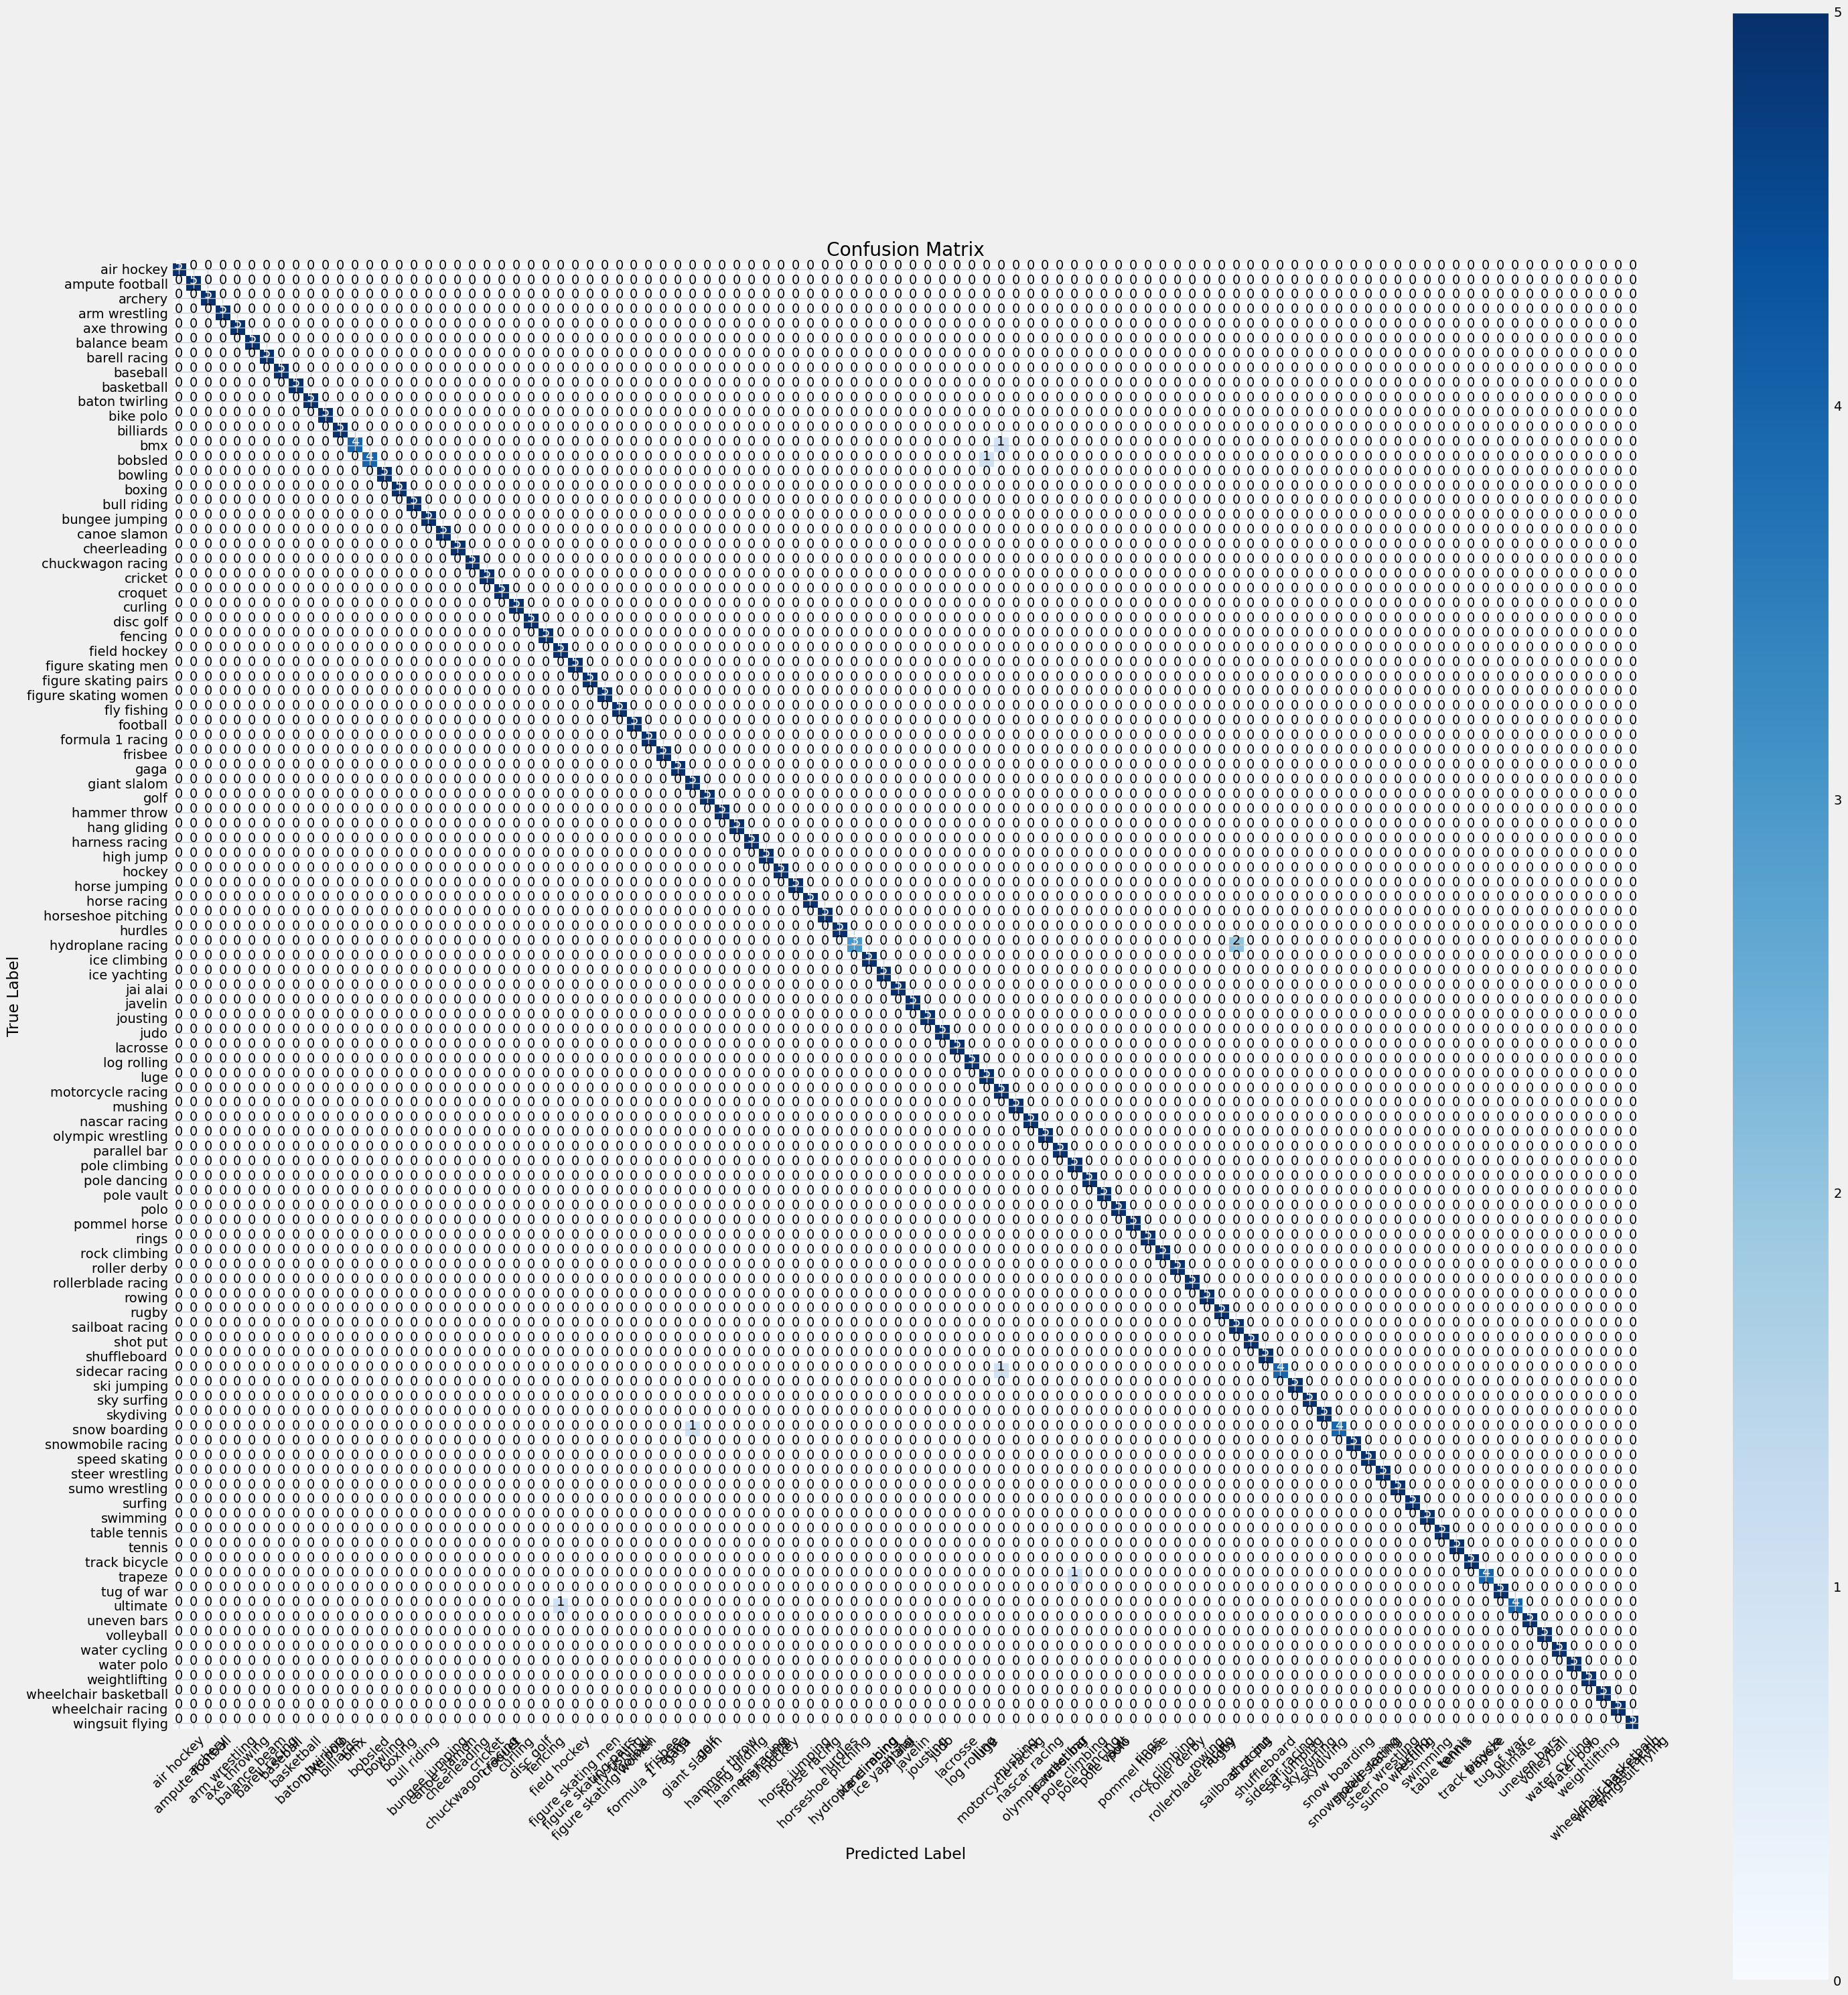

In [20]:
preds = model.predict_generator(test_images)
y_pred = np.argmax(preds, axis=1)
g_dict = test_images.class_indices
classes = list(g_dict.keys())

cm = confusion_matrix(test_images.classes, y_pred)

plt.figure(figsize= (30, 30))
plt.imshow(cm, interpolation= 'nearest', cmap= plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()

tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation= 45)
plt.yticks(tick_marks, classes)


thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j], horizontalalignment= 'center', color= 'white' if cm[i, j] > thresh else 'black')

plt.tight_layout()
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

plt.show()

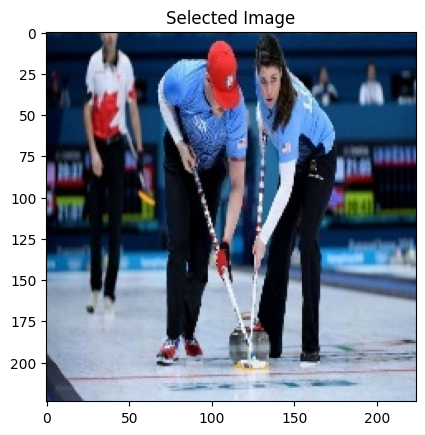

1/1 [==============================] - 1s 1s/step
Selected Image: curling\3.jpg, Predicted Class: curling


In [23]:
import os
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img, img_to_array

model = tf.keras.models.load_model('sports_model_efficient_net.h5')

test_folder = "C:\\Users\\chakr\\OneDrive\\Desktop\\SmartBridge\\Project\\model\\archive\\test"
test_image_rel_path = "curling\\3.jpg"

class_names = sorted(os.listdir(test_folder))

image_path = os.path.join(test_folder, test_image_rel_path)
img = load_img(image_path)
img_array = img_to_array(img)
img_array = img_array.reshape((1,) + img_array.shape)

plt.imshow(img)
plt.title("Test Image")
plt.show()

predictions = model.predict(img_array)

predicted_class_index = np.argmax(predictions, axis=1)
predicted_class_name = class_names[predicted_class_index[0]]
print(f"Selected Image: {test_image_rel_path}, Predicted Class: {predicted_class_name}")